# _In-Silico_ Solvent Optimization Study

This is a test problem to compare how optimization with black-box algorithms does vs. with molecular descriptors.

You should describe the kinetic model used to generate experimental data and the nature of the pareto front.

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from surrogate_model_functions import plot_3d_model, loo_error
from solvent_optimization import (descriptors_optimization, Experiments, create_pcs_ds, create_domain,
                                  generate_initial_experiment_data, SolventEvolutionaryOptimization,
                                  fullfact)
from summit.strategies import _pareto_front
from summit.data import DataSet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

In [29]:
#Solvent Dataset compressed to 3 principal components
solvent_ds_pcs = create_pcs_ds(num_components=3)

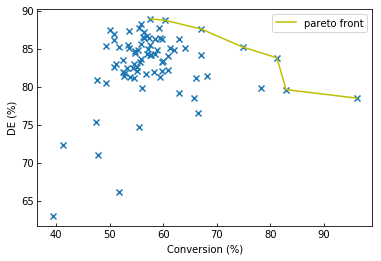

In [31]:
#Visualize all potential experiments
random_state = np.random.RandomState(1000)
exp = Experiments(solvent_ds_pcs, random_state)
all_experiments = [exp.run(cas) 
                   for cas in solvent_ds_pcs.index.values]
all_experiments = np.array(all_experiments)
pareto, pareto_indices = _pareto_front(all_experiments)
ax = plt.subplot(111)
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front')
ax.legend()
ax.tick_params(direction='in')
plt.savefig('outputs/in_silico_experiment_space.png')
plt.savefig('outputs/in_silico_experiment_space.svg')

In [32]:
#Dsiplay pareto front solvents
solvents_pareto = solvent_ds_pcs.iloc[pareto_indices, :]
solvents_pareto

,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name,PC_1,PC_2,PC_3
cas_number,,,,,,,,
56-81-5,"1,2,3-propanetriol",glycerol,C3H8O3,Alcohol,Glycerol,5.691078,3.500596,4.144049
111-87-5,octanol,1-octanol,C8H18O,Alcohol,1-Octanol,-1.606167,2.340934,2.924488
126-33-0,sulfolane,"tetrahydrothiophene-1,1-dioxide",C4H8O2S,Dipolar aprotic,Sulfolane,3.556021,4.489360,-1.491517
100-51-6,benzyl alcohol,benzylalcohol,C7H8O,Alcohol,Benzyl Alcohol,0.835884,2.302094,2.452315
96-49-1,"1,3-dioxolan-2-one","1,3-dioxolan-2-one",C3H4O3,Dipolar aprotic,Ethylene carbonate,5.201828,2.713061,-1.247649
7226-23-5,"1,3-dimethyltetrahydropyrimidin-2(1H)-one","1,3-dimethyltetrahydropyrimidin-2(1h)-one",C6H12N2O,Dipolar aprotic,Dimethyl phosphonyl urea (DMPU),0.420531,3.248744,-0.349683
123-92-2,3-methylbutyl acetate,isoamylacetate,C7H14O2,Ester,Isoamyl acetate,-2.501153,1.622836,-0.238475


In [6]:
#Optimization parameters
batch_size=8
num_batches=5
num_components=3
random_seed=1000

## 1. Black-Box Optimization vs Molecular Descriptors Optimization

In [12]:
s = SolventEvolutionaryOptimization(batch_size=10,
                                    num_batches=10,
                                    seed=random_seed)
final_pop = s.optimize()

In [13]:
s.solvents_evaluated

['67-64-1',
 '110-19-0',
 '98-08-8',
 '110-86-1',
 '1634-04-4',
 '105-58-8',
 '98-82-8',
 '108-32-7',
 '108-94-1',
 '71-43-2']

In [199]:
domain = create_domain(solvent_ds_pcs)
initial_experiments = generate_initial_experiment_data(domain, solvent_ds_pcs, batch_size, np.random.RandomState(random_seed))
initial_experiments.data_to_numpy()[:, (0,1)].astype(np.float64).tolist()

[[56.408818233668576, 82.08434586550139],
 [59.96303724621016, 81.7313710220598],
 [53.96234511151754, 65.93796307191388],
 [65.36739925184239, 85.85797482185541],
 [53.99268161559287, 81.05728229013691],
 [56.85580262454598, 87.75317722415946],
 [76.44423580861385, 82.06919691511632],
 [77.03505227618939, 83.54337071139315]]

In [193]:
s.solvents_evaluated

['67-64-1',
 '110-19-0',
 '98-08-8',
 '110-86-1',
 '1634-04-4',
 '105-58-8',
 '98-82-8',
 '108-32-7']

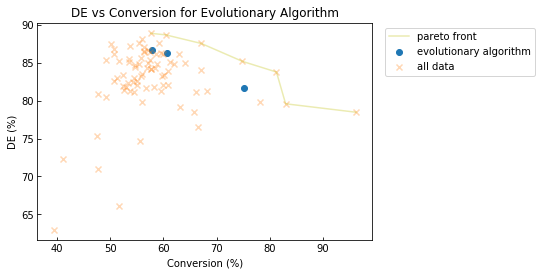

In [187]:
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
ax.scatter(final_pop[:, 0], final_pop[:, 1], label='evolutionary algorithm')
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x', alpha=0.3, label='all data')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front', alpha=0.3)
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
_ = ax.set_title('DE vs Conversion for Evolutionary Algorithm')

# ec_coverages = np.zeros(num_batches)
# pareto_size = solvents_pareto.shape[0]
# candidates = 
# solvents_pareto.index.values.any() == batches['solvent']
#     num_covered = np.count_nonzero(check)
#     ec_coverages[i] = num_covered/pareto_size*100


In [166]:
s.solvents_evaluated

['67-64-1',
 '110-19-0',
 '98-08-8',
 '110-86-1',
 '1634-04-4',
 '105-58-8',
 '98-82-8',
 '108-32-7']

## 2.Tuning Molecular Descriptors Optimization

Simulations were run with 50 repeats.

### DoE Study

In [34]:
#Calculate pareto coverage for various optimization settings
num_repeats = 50
num_tests = 16
metadata = num_tests*[0]
experiments = [[0 for _ in range(num_repeats)] for _ in range(num_tests)]
coverages = np.zeros([num_tests, num_repeats])
pareto_size = solvents_pareto.shape[0]
for i in range(num_tests):
    with open(f"outputs/test_{i}_in_silico_metadata.json", 'r') as f:
        metadata[i] = json.load(f)
    for j in range(num_repeats):
        exps = DataSet.read_csv(f"outputs/test_{i}_iteration_{j}_in_silico_experiments.csv")
        check = solvents_pareto.index.values.any() == exps['solvent']
        num_covered = np.count_nonzero(check)
        coverages[i, j] = num_covered/pareto_size*100

In [75]:
#Make table of pareto coverages for various settings of optimization parameters
columns = ['batch_size', 
           'normalize_inputs',
           'normalize_outputs',
           'design_criterion',
           'pareto_coverage']
df = pd.DataFrame(metadata)
df = df[['batch_size', 
         'normalize_inputs',
         'normalize_outputs']]
coverages_mean = np.mean(coverages, axis=1)
coverages_std_dev = np.std(coverages, axis=1)
column = [f'{round(mean)}±{std}' for mean, std in zip(coverages_mean, coverages_std_dev)]
df.insert(df.shape[1],'coverages', column)
df

,batch_size,normalize_inputs,normalize_outputs,coverages
0,4,False,False,15.0±2.0
1,4,True,False,14.0±0.0
2,4,False,True,14.0±0.0
3,4,True,True,14.0±0.0
4,8,False,False,29.0±0.0
5,8,True,False,29.0±0.0
6,8,False,True,29.0±0.0
7,8,True,True,29.0±0.0
8,4,False,False,14.0±0.0
9,4,True,False,14.0±0.0


In [92]:
#Reconstruct full factorial design
num_components =3
params = {'normalize_inputs': [False, True],
          'normalize_outputs': [False, True],
          'batch_size': [4, 8],
          'design_criterion': ['center', 'maximin']}
levels = [len(params[key]) for key in params]
doe = fullfact(levels)

#Calculate primary and secondary effects
num_params = len(params)
pmary_effects = np.zeros(num_params)
sdary_effects = np.zeros((num_params-1)*num_params)
sdary_names = (num_params-1)*num_params*['']
ones = np.nonzero(doe)
zeros = np.where(doe==0)
j=0
for param_index, key in enumerate(params):
    highs_where = np.where(ones[1] == param_index)[0]
    lows_where = np.where(zeros[1]==param_index)[0]
    highs_indices = ones[0][highs_where]
    lows_indices = zeros[0][lows_where]
    
    #Calculate primary effects
    highs = coverages_mean[highs_indices]
    lows = coverages_mean[lows_indices]
    pmary_effects[param_index] = 0.5*(np.sum(highs-lows))/highs.shape[0]
    
    #Calculate secondary effect
    
    for sdary_index, sdary_key in enumerate(params):
        if sdary_index == param_index: continue
        sdary_highs_where = np.where(ones[1] == sdary_index)[0]
        sdary_lows_where = np.where(zeros[1]==sdary_index)[0]
        sdary_highs_indices = ones[0][sdary_highs_where]
        sdary_lows_indices = zeros[0][sdary_lows_where]
        
        sdary_highs_indices = np.intersect1d(highs_indices, sdary_highs_indices)
        sdary_lows_indices  = np.intersect1d(lows_indices, sdary_lows_indices)
        
        sdary_highs = coverages_mean[sdary_highs_indices]
        sdary_lows = coverages_mean[sdary_lows_indices]
        sdary_effects[j] = 0.5*(np.sum(sdary_highs-sdary_lows))/sdary_highs.shape[0]
        sdary_names[j] = f"{key}*{sdary_key}"
        j+=1

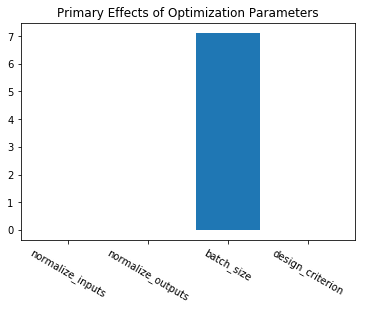

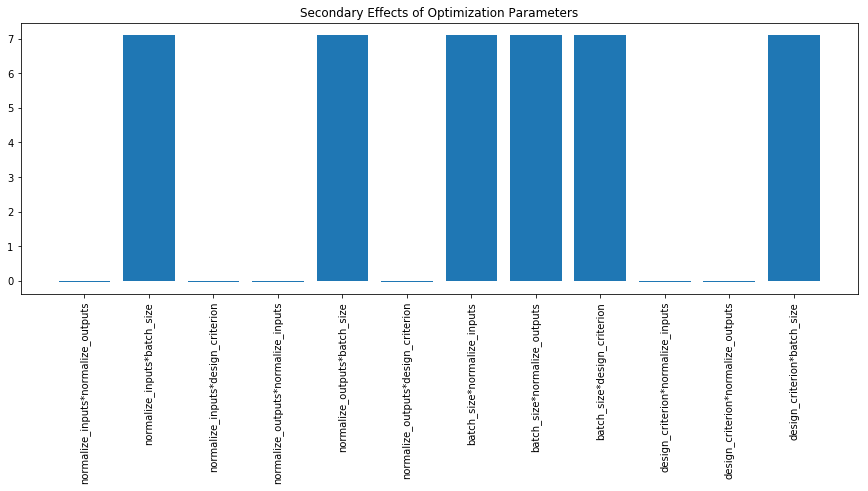

In [93]:
#Plot Primary effects
plt.figure()
plt.bar(np.arange(num_params), pmary_effects)
plt.xticks(np.arange(num_params), [param for param in params], rotation=-30)
_ = plt.title('Primary Effects of Optimization Parameters')

#Plot secondary effects
plt.figure(figsize=(15,5))
ind = np.arange((num_params-1)*num_params)
plt.bar(ind, sdary_effects)
plt.xticks(ind, sdary_names, rotation='vertical')
_ = plt.title('Secondary Effects of Optimization Parameters')

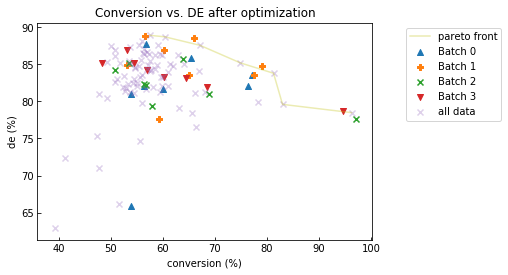

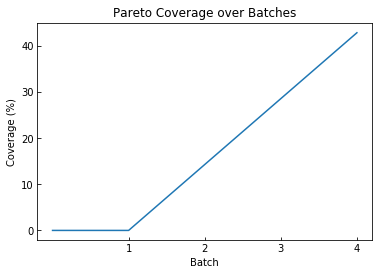

In [106]:
#Visualize the optimization data
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
markers = ['^', 'P', 'x', 'v', 'p', 'o', 's', '>', 'D', '<', '*']
for i in range(4): 
    data = experiments[experiments['batch']==float(i)].data_to_numpy()
    ax.scatter(data[:, 0], data[:, 1], marker=markers[i],label=f"Batch {i}")
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x', alpha=0.3, label='all data')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front', alpha=0.3)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.xlabel('conversion (%)'); plt.ylabel('de (%)')
plt.title('Conversion vs. DE after optimization')
plt.savefig('outputs/solvent_optimization_molecular_descriptors.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors.svg')

coverages = np.zeros(num_batches)
pareto_size = solvents_pareto.shape[0]
for i in range(num_batches):
    batches = experiments[experiments['batch']<= i]
    check = solvents_pareto.index.values.any() == batches['solvent']
    num_covered = np.count_nonzero(check)
    coverages[i] = num_covered/pareto_size*100
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
ax.plot(np.arange(0, num_batches, 1, dtype=int), coverages)
ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
ax.set_xlabel('Batch'); ax.set_ylabel('Coverage (%)')
_ = ax.set_title('Pareto Coverage over Batches')

### Stopping Criteria

In [16]:
num_tests = 16
lengthscales = num_tests*[0]



(50, 9, 3, 2)

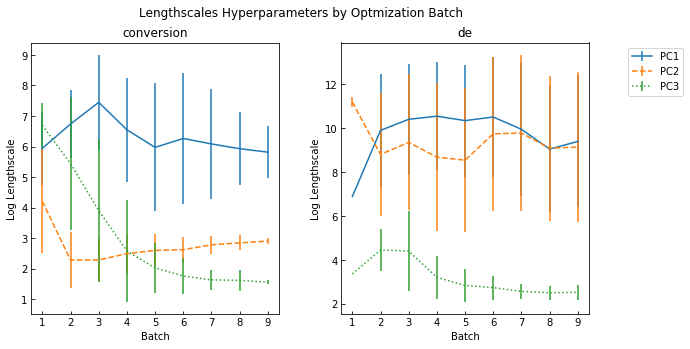

In [25]:
test = 1
for i in range(num_tests):
    lengthscales[i] = np.load(f"outputs/test_{i}_in_silico_lengthscales.npy")
lengthscales[0].shape      
l= np.average(np.log(lengthscales[test]), axis=0)
l_std_dev = np.std(np.log(lengthscales[test]), axis=0)
num_components = 3
num_batches = 10

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
titles = ['conversion', 'de']
for i, ax in enumerate(axes):
    for j in range(num_components):
        ax.errorbar(np.arange(1, num_batches, 1, dtype=int), l1[:, j, i], 
                    yerr=l1_std_dev[:, j, i],
                    linestyle=linestyles[j], label=f'PC{j+1}')
    ax.set_ylabel('Log Lengthscale')
    ax.set_xlabel('Batch')
    ax.set_title(titles[i])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
axes[1].legend(bbox_to_anchor=(1.4, 1))
fig.suptitle('Lengthscales Hyperparameters by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_lengthscales.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_lengthscales.svg')

Though the pareto coverage statistics aren't great, the algorithm does does pick several solvents, which are close to the pareto front.  The one issue is that there is a signficant amount of clustering of the solvents in one area of the output space, so there is a lot of sampling from that region. Finding some way to introduce more randomness (i.e., exploring) might be helpful.

The GP model identifies that PC<sub>1</sub> is not relevant. The problem is that PC<sub>1</sub> is usually not relevant except in a special case: when PC<sub>1</sub> is large and PC<sub>2</sub> and PC<sub>3</sub> are small. This sort of intertwined behavior might only be able to be captured by an additive or multiplicative kernel. 

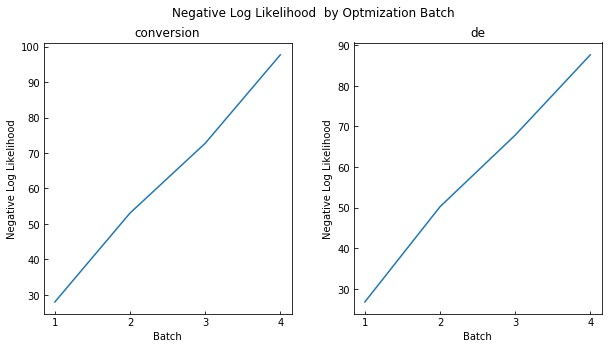

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
for j, ax in enumerate(axes):
    ax.plot(np.arange(1, num_batches, 1, dtype=int), -log_likelihoods[:,j])
    ax.set_ylabel('Negative Log Likelihood')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
fig.suptitle('Negative Log Likelihood  by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.svg')

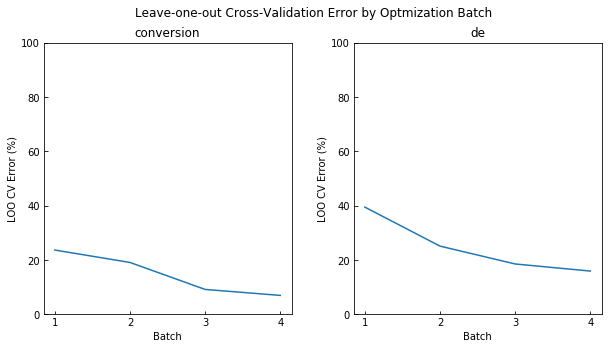

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
for j, ax in enumerate(axes):
    ax.plot(np.arange(1, num_batches, 1, dtype=int), loo_errors[:,j]*100)
    ax.set_ylabel('LOO CV Error (%)')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.set_ylim(0, 100)
    ax.tick_params(direction='in')
fig.suptitle('Leave-one-out Cross-Validation Error by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_cv.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_cv.svg')